# Step 1: loading data
Load businesses, users and reviews

In [139]:
import pandas as pd
import json
import os
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

# Create a tuple of the address of the business files E.g. ('./yelp/data/110 las vegas', 'business.json')
# AllUserFilePaths=[(subdir,file) for subdir, dirs, files in os.walk('./yelp/data/') for file in files if file == 'user.json']
AllReviewFilePaths=[(subdir,file) for subdir, dirs, files in os.walk('./yelp/data/') for file in files if file == 'review.json']
AllBusinessFilePaths=[(subdir,file) for subdir, dirs, files in os.walk('./yelp/data/') for file in files if file == 'business.json']

# Merge the dataframes of these files and reset the index
# AllUserMerged=pd.concat([load_jsons(x[0]+'/',x[1]) for x in AllUserFilePaths]).reset_index(drop=True)
AllReviewMerged=pd.concat([load_jsons(x[0]+'/',x[1]) for x in AllReviewFilePaths]).reset_index(drop=True)
AllBusinessMerged=pd.concat([load_jsons(x[0]+'/',x[1]) for x in AllBusinessFilePaths]).reset_index(drop=True)


In [140]:
AllBusinessMerged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"9827 W Tropicana Ave, Ste 100",{'BusinessAcceptsCreditCards': 'True'},M82c96ICluambjx0wWg6Bg,"Automotive, Auto Repair, Oil Change Stations, ...",110 Las Vegas,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",0,36.099575,-115.306722,ABZ Auto Care,89147,68,5.0,NV
1,3850 Sheppard Avenue E,"{'GoodForMeal': '{'dessert': False, 'latenight...",U_ihDw5JhfmSKBUUkpEQqw,"Burgers, Restaurants, Fast Food",Agincourt,"{'Monday': '7:0-11:0', 'Tuesday': '7:0-11:0', ...",1,43.784517,-79.291325,McDonald's,M1T 3L4,5,2.5,ON
2,2936 Finch Avenue E,"{'HasTV': 'True', 'RestaurantsGoodForGroups': ...",LixFCMGKdptI8WRsjAl5cQ,"Fast Food, Restaurants, Burgers",AGINCOURT,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,43.794305,-79.329995,McDonald's,M1W 2T4,7,2.0,ON
3,,{'BusinessAcceptsCreditCards': 'True'},064fFc4CdNxAJJDVR-7FSQ,"Home Cleaning, Professional Services, Home Ser...",Ahwahtukee,"{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ...",1,33.321112,-111.988020,Horton Carpet Cleaning,85044,17,5.0,AZ
4,10823 S 51st St,"{'Alcohol': 'u'none'', 'RestaurantsReservation...",UY1BHeeb1oE0-uk0EKqaGg,"Food, Burgers, Fast Food, Restaurants",Ahwatukee,None,0,33.348551,-111.975151,McDonald's,85044,7,1.5,AZ


In [146]:
AllReviewMerged.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,M82c96ICluambjx0wWg6Bg,70,2015-11-18 20:01:15,35,U2DCXuY8cnqEXKiDM2StVg,5.0,"Best place to take your Car , no BS and hones...",70,arH9TJhwjaSh8qVnJ7nmTQ
1,M82c96ICluambjx0wWg6Bg,67,2016-07-14 21:50:48,34,PlsccX4ZGkWNbImY_UBkbw,5.0,I just moved here to Las Vegas and was looking...,68,fZmlBl4hVOm-A7xFJ14vAA
2,M82c96ICluambjx0wWg6Bg,30,2017-07-28 21:53:34,29,UuyZlQu9Cn44BM7EEiHkjg,5.0,Shlomi is one of the best mechanics in Las Veg...,30,9oPadfz_B_uzCKMRZq2CHg
3,M82c96ICluambjx0wWg6Bg,81,2016-03-31 22:27:59,31,0URo0Dp6t1cQiBTMCwqUgQ,5.0,I called first to find out rates. Shlomi took ...,83,sLCVE32lUjPit-kUvlZg2w
4,M82c96ICluambjx0wWg6Bg,41,2017-08-08 19:10:43,39,ITG1-seS_pi32XEJxfff3Q,5.0,"Went in for a smog check. No waiting, did the...",41,a2cPSPOgHSSsrMtqYBjk0w


# Step 2: Making the helper functions
Helping the big function to function in a normal way

In [141]:
import numpy as np
import scipy.stats
from operator import itemgetter
from itertools import chain

def lower_bound_confidence_interval(data, confidence=0.95):
    # The lower bound is taken from the ratings provided to ensure that a business with less noise in the rating is rated higher
    # than one with the occasional 5. If business A has consistently been rated with 3.5 and 4 stars, it certainly trumps
    # Business B who most of the time gets rated 2.5 stars but used bots to increase his rating.
    #     
    # Parameters:
    #    
    # Data: A list of ratings. May be any type of number
    #         
    # confidence: The confidence level that will be sought as the lower bound. 95% provides the most certainty which is the reason for
    # for the assumption of 0.95.  If not given, 0.95 is assumed. 
    
    # The function below requires a list of floats so we do make sure everything is indeed a float
    
    a = list(map(float, data))
    return np.mean(a)-scipy.stats.sem(a) * scipy.stats.t.ppf((1 + confidence) / 2., len(a)-1)

def JaccardSimilarity(business_ids):
    
    # Calculates the Jaccard Similarity by taking the business_ids of a recommendation. Calculated by (Set of categories of
    # recommendation) / (All categories available)
    #     
    # Parameters:
    #    
    # NumberOfPreds: The business ID's of the already made recommendation
    
    CategoriesOfPreds=set([y.strip() for y in AllBusinessMerged[AllBusinessMerged['business_id']==x]['categories'].values[0].split(',') for x in business_ids])
    AllCategories=set(list(chain.from_iterable([category.split(',') for category in AllBusinessMerged['categories'] if category])))   
    return len(CategoriesOfPreds)/len(AllCategories)

def diversify(data,NumberOfPreds=5,occs=2):
    # Creates variation in the recommendations. When the maximum occurence of a category has been reached, the category will
    # not be recommended any further.       
    # 
    # Parameters:
    #
    # data: A list in tuples with the Business ID in the first and the lower bound confidence interval in the second position
    #     
    # NumberOfPreds: The amount of desired predictions that will result from this function. If not given, 5 is assumed.
    #         
    # occs: The maximum allowed occurence of a category in a recommendation.  If not given, 2 is assumed.   
    
    Eindresultaat=[]
    allCategories=[]

    for item in data:
        if len(Eindresultaat)==NumberOfPreds:
            return Eindresultaat
    #   check the occurence of the categories of a business and mark it as duplicate if it is.
        duplicate=False
        CategoriesOfOneBusiness=[]
        for categories in AllBusinessMerged[AllBusinessMerged['business_id']==item[0]]['categories'].values:
            for category in categories.split(','):
                if occs == allCategories.count(category.strip()):
                    duplicate=True
    #   If the category is diverse enough and the business is trading, it will be recommended and added to the already 
    #   recommended categories.      
        if not duplicate and int(AllBusinessMerged[AllBusinessMerged['business_id']==item[0]]['is_open'].values):
            for categories in AllBusinessMerged[AllBusinessMerged['business_id']==item[0]]['categories'].values:
                for category in categories.split(','):
                    allCategories.append(category.strip())
            Eindresultaat.append(item) 
    # If NumberOfPreds has not been reached, whatever has been recommended so far will be recommended
    return Eindresultaat

# Step 3: The big boy function
The big boy that takes all the helper function and returns the recommendations

In [142]:
def predictColdStart(NumberOfPreds=5,RepetionsOfCategories=2,MinimalAmountOfReviews=1800):
    # Recommends if insufficient data is available. Because we can not determine the location of the user if there is too little
    # information, we can not take the geographic location of the user into account. Thus we can only give the most popular places
    # in the database. The usage of the lower bound of the normal confidence interval is explained at its respective function.
    #     
    # Parameters:
    #    
    # NumberOfPreds: The amount of desired predictions that will result from this function. If not given, 5 is assumed.
    #         
    # RepetionsOfCategories: The maximum allowed occurence of a category in a recommendation.  If not given, 2 is assumed.   
    #     
    # MinimalAmountOfReviews: The minimal amount of reviews a business has to have before being considerd for a Cold Start
    #                         recommendation. This parameter is not only implemented for the sake of a reduction of computations 
    #                         but also because a business with 1 5-star rating can not be rated higher than a business with 1800
    #                         1800 4-star ratings.
    
    ReviewAmountSorted=AllReviewMerged.groupby('business_id').size().sort_values(ascending=False)
    
    # Although it reduces readability, the list comprehension reduces computational costs which is essential because of the 
    # volume of the dataset. Down below an example of the computational time of a for-loop and a list comprehension for a 
    # MinimalAmountOfReviews of 1800:
    # Loop time:                  57.899160861968994
    # List comprehension time:    54.47058868408203
    
    alles=[(ReviewAmountSorted.index[x],lower_bound_confidence_interval(AllReviewMerged.loc[AllReviewMerged['business_id'] ==ReviewAmountSorted.index[x]]['stars'].values)) for x in np.where(ReviewAmountSorted.between(MinimalAmountOfReviews,ReviewAmountSorted[0]))[0]]
    tussenresultaat=diversify(sorted(alles,key=itemgetter(1),reverse=True),NumberOfPreds=NumberOfPreds)
    return pd.Series(data=[i[1] for i in tussenresultaat],index=[i[0] for i in tussenresultaat])

# Step 4: Evaluating the algorithm
How does the algorithm perform

In [143]:
example=predictColdStart()
display(AllBusinessMerged.loc[AllBusinessMerged['business_id'].isin(list(example.index))])

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
59795,"The Mirage Hotel Casino, 3400 Las Vegas Blvd S","{'BusinessParking': '{'garage': True, 'street'...",mz9ltimeAIy2c2qf5ctljw,"Arts & Entertainment, Music Venues, Nightlife,...",Las Vegas,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-18:0'...",1,36.121324,-115.174956,Cirque du Soleil - The Beatles LOVE,89109,1980,4.5,NV
66806,2600 W Harmon Ave,"{'RestaurantsPriceRange2': '3', 'BusinessAccep...",WYw3Uf56DT5IwpaLNnCH5Q,"Resorts, Day Spas, Hotels & Travel, Event Plan...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.109301,-115.178147,Vdara Hotel & Spa at ARIA Las Vegas,89158,2543,4.0,NV
66914,3131 Las Vegas Blvd S,"{'GoodForKids': 'False', 'BusinessAcceptsCredi...",t-o_Sraneime4DDhWrQRBA,"Active Life, Hotels & Travel, Casinos, Golf, E...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.127684,-115.165905,Wynn Las Vegas,89109,2795,4.0,NV
76812,"5693 S Jones Blvd, Ste 106","{'GoodForKids': 'True', 'RestaurantsAttire': '...",mDR12Hafvr84ctpsV6YLag,"Breakfast & Brunch, Burgers, Sandwiches, Resta...",Las Vegas,"{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...",1,36.086287,-115.226134,Mr Mamas,89118,2519,4.5,NV
122453,4301 E University Dr,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",Xg5qEQiB-7L6kGJ5F4K3bQ,"Barbeque, Restaurants",Phoenix,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ...",1,33.421877,-111.989344,Little Miss BBQ,85034,1936,5.0,AZ


Xg5qEQiB-7L6kGJ5F4K3bQ    4.750960
mDR12Hafvr84ctpsV6YLag    4.605711
mz9ltimeAIy2c2qf5ctljw    4.328782
t-o_Sraneime4DDhWrQRBA    3.932575
WYw3Uf56DT5IwpaLNnCH5Q    3.764400
dtype: float64


,Business ID,Predicted Rating,RMSE,MAE,MAPE
1,Xg5qEQiB-7L6kGJ5F4K3bQ,4.750960,0.660154,0.401922,13.430810
2,mDR12Hafvr84ctpsV6YLag,4.605711,0.787607,0.574419,18.715428
3,mz9ltimeAIy2c2qf5ctljw,4.328782,1.047926,0.840471,30.831568
4,t-o_Sraneime4DDhWrQRBA,3.932575,1.389513,1.129438,54.882167
5,WYw3Uf56DT5IwpaLNnCH5Q,3.764400,1.270705,1.028700,46.979958


Text(1, 1.1, "RMSE, MAE and MAPE's of the predictions (Jaccard Similarity = 0.00365):")

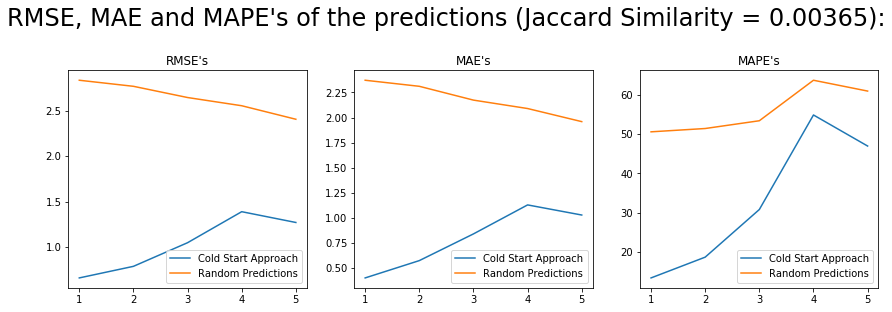

In [144]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statistics import mean
from random import choices
print(example)
rmse=[]
mae=[]
mape=[]
for x in example.index:
    targets=AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars']
    predictions=[lower_bound_confidence_interval(AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars'].values)]*len(targets)
    rmse.append(np.sqrt(((predictions - targets) ** 2).mean()))
    mae.append(sum(abs(predictions - targets))/len(targets))
    mape.append(mean(abs(predictions - targets)/abs(targets))*100)
display(pd.DataFrame(index=range(1,len(example.index)+1),data={'Business ID':example.index,'Predicted Rating':example.values,'RMSE':rmse,'MAE':mae,'MAPE':mape}))
rmseRand=[]
maeRand=[]
mapeRand=[]
for x in example.index:
    targets=AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars']
    predictions=choices([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],k=len(targets))
    rmseRand.append(np.sqrt(((predictions - targets) ** 2).mean()))
    maeRand.append(sum(abs(predictions - targets))/len(targets))
    mapeRand.append(mean(abs(predictions - targets)/abs(targets))*100)
%matplotlib inline  
fig, axs = plt.subplots(1,3)
plt.subplots_adjust(right=2)
axs[0].plot(range(1,len(example.index)+1),rmse,label="Cold Start Approach")
axs[0].plot(range(1,len(example.index)+1),rmseRand,label="Random Predictions")
axs[0].legend(loc="lower right")
axs[0].set_title("RMSE's")
axs[1].plot(range(1,len(example.index)+1),mae,label="Cold Start Approach")
axs[1].plot(range(1,len(example.index)+1),maeRand,label="Random Predictions")
axs[1].legend(loc="lower right")
axs[1].set_title("MAE's")
axs[2].plot(range(1,len(example.index)+1),mape,label="Cold Start Approach")
axs[2].plot(range(1,len(example.index)+1),mapeRand,label="Random Predictions")
axs[2].legend(loc="lower right")
axs[2].set_title("MAPE's")
RipErasmus="RMSE, MAE and MAPE's of the predictions (Jaccard Similarity = "+str(round(JaccardSimilarity(example.index),5))+"):"
fig.suptitle(RipErasmus,y=1.1,x=1,fontsize=24)

C:\Users\Rabie\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


Text(0, 0.5, 'precision')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


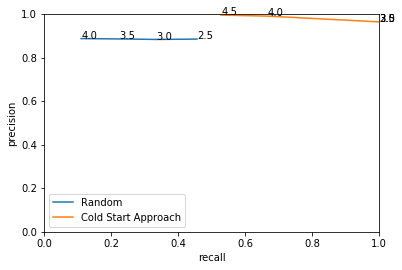

In [145]:
def recommended(predictions, treshold):
    return predictions[predictions['predicted rating']>treshold]

def hidden(predictions, treshold):
    return predictions[predictions['predicted rating']<treshold]

def used(predictions, treshold):
    return predictions[predictions['rating']>=treshold]   

def unused(predictions, treshold):
    return predictions[predictions['rating']<treshold]

def confusion(recommended, hidden, used, unused):
    return pd.DataFrame([[pd.merge(recommended,used, how='inner').shape[0], pd.merge(recommended,unused, how='inner').shape[0]], [pd.merge(hidden,used, how='inner').shape[0], pd.merge(hidden,unused, how='inner').shape[0]]], columns=['used', 'unused'],
                         index=['recommended', 'hidden'])

def precision(confusion_matrix):
    return confusion_matrix.loc['recommended']['used']/confusion_matrix.loc['recommended'].values.sum()

def recall(confusion_matrix):
    return confusion_matrix.loc['recommended']['used']/confusion_matrix['used'].values.sum()

def calculateRecallFromStart(data,treshold_recommended,treshold_used):
    return recall(confusion(recommended(data, treshold_recommended), hidden(data, treshold_recommended), used(data, treshold_used), unused(data, treshold_used)))
def calculatePrecisionFromStart(data,treshold_recommended,treshold_used):
    return precision(confusion(recommended(data, treshold_recommended), hidden(data, treshold_recommended), used(data, treshold_used), unused(data, treshold_used)))

treshold_used = 3.75

tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

targets=[y for y in AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars'] for x in example.index]
predictions=choices([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5],k=len(targets))
precisons=[]
recalls=[]
for treshold_recommended in tresholds:
    precisons.append(calculatePrecisionFromStart(pd.DataFrame(data={'rating':targets,'predicted rating':predictions}),treshold_recommended,treshold_used))
    recalls.append(calculateRecallFromStart(pd.DataFrame(data={'rating':targets,'predicted rating':predictions}),treshold_recommended,treshold_used))
plt.plot(recalls,precisons,label='Random')
for r, p, t in zip(recalls, precisons, tresholds):
    plt.text(r, p, t)

targets=[]
predictions=[]
for x in example.index:
    targets.append(AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars'])
    predictions.append([lower_bound_confidence_interval(AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars'].values)]*len(AllReviewMerged.loc[AllReviewMerged['business_id'] ==x]['stars']))
precisons=[]
recalls=[]
# flatten lists
targets=list(itertools.chain(*targets))
predictions=list(itertools.chain(*predictions))
for treshold_recommended in tresholds:
    precisons.append(calculatePrecisionFromStart(pd.DataFrame(data={'rating':targets,'predicted rating':predictions}),treshold_recommended,treshold_used))
    recalls.append(calculateRecallFromStart(pd.DataFrame(data={'rating':targets,'predicted rating':predictions}),treshold_recommended,treshold_used))

plt.plot(recalls,precisons,label='Cold Start Approach')
plt.legend()
for r, p, t in zip(recalls, precisons, tresholds):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')
# plt.savefig('books_read.png')